# NEWS_crawling

In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [3]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [4]:
code_list = [101, 102, 103]

code_list

[101, 102, 103]

In [5]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

# 1달 간의 데이터를 수집

In [ ]:
def make_1_month_data(page_num, code_list, date):
    df = None
    
    for i in range(0,28):
        df_temp = make_total_data(page_num, code_list, date+i) 
            
        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
    return df

# 1년 간의 데이터를 수집

In [6]:
def make_1_year_data(page_num, code_list, date):
    df = None
    
    for i in range(0,12):
        df_temp = make_total_data(page_num, code_list, date+i*100) 
            
        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
    return df

# 데이터 프레임 생성 및 저장

In [7]:
df = make_1_year_data(2, code_list, 20190101)

101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.


In [8]:
type(df)

pandas.core.frame.DataFrame

In [9]:
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_2019_none.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/home/aiffel/aiffel/news_crawler/news_data_2019_none.csv File Saved!


In [10]:
import pandas as pd
import os
csv_path1 = os.getenv("HOME") + "/aiffel/news_crawler/news_data_2019_none.csv"
df = pd.read_table(csv_path1, sep=',')

In [11]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  1440


In [12]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       동영상 뉴스직장인과 구직자 그리고 자영업자들이 새해 소망을 담은 사자성어로 마고소양...
1       동영상 뉴스지난해 자영업자의 체감 경기지수가 사상 최대 폭으로 떨어진 것으로 나타났...
2       구윤철 기획재정부 차관과 신재민 전 기재부 사무관 구 차관은 지난달 일 긴급 브리핑...
3       에이징 한우 등심이마트 에이징 한우 등심이마트서울경제 바로가기애플워치가 쏟아집니다 ...
4       이낙연 국무총리 연합뉴스 제공세종이데일리 이진철 기자 이낙연 국무총리는 일 올해 경...
                              ...                        
1435    갓세븐 영재연합뉴스 자료사진 갓세븐 영재연합뉴스 자료사진갓세븐 잭슨엔터테인먼트 제공...
1436    월에 접어들면서 본격적인 겨울이 찾아왔다 기상청은 이번 주 내내 전국 대부분 지역의...
1437    별세한 마리스 얀손스빈체로 제공 재판매 및  금지 별세한 마리스 얀손스빈체로 제공 ...
1438    라트비아 출신의 지휘계 거장 마리스 얀손스사진가 지난달 일 러시아 상트페테르부르크 ...
1439    사진이상섭 기자  사진이상섭 기자 헤럴드경제 월요일인 일 전국이 대체로 흐린 날씨를...
Name: news, Length: 1440, dtype: object

# NULL값 확인 및 중복된 샘플 제거

In [13]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [14]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  1279


In [15]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  1279


<AxesSubplot:>

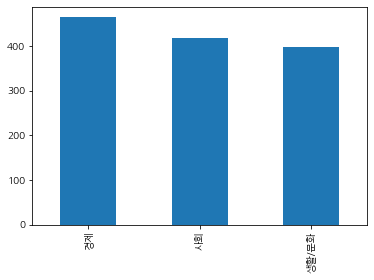

In [16]:
import matplotlib as mpl
import matplotlib.pylab as plt

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'


df['code'].value_counts().plot(kind = 'bar')

In [17]:
from konlpy.tag import Mecab
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Okt
tokenizer = Mecab()

# 불용어 처리

In [18]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','따른','및','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','까지', '고', '지','렸', '되','재배포','일보','혔','를','함께', '된', '졌','송고','었','였','저작권자','겟','때문','매우','할','으로','한편','연합뉴스','된','더팩트','뉴시스','서울신문','한국일보','동아일보','부산일보','아시아경제','서울신문','한국경제','중앙일보','조선일보','노컷뉴스','프레시안','경향신문','조선','머니','국민일보','세계일보','채널','이데일리','한겨레','여성신문','머니투데이','투데이','며','겠','다는','전','낼','도록','라며','라고','에서','가운데','와','닫','습니다','부터','위해','지난달','으며','오후','오전','배포','네이버','제보','기다립니다','무단','통해','될','로','도','메인','여러분','코리아','그래도','재','설정','모두','신문','다며','금지','동영상','세종']

In [19]:
len(stopwords)

117

In [20]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [21]:
text_data = preprocessing(df['news'])

In [22]:
print(text_data[0])

직장인 구직자 그리고 자영업 자 새해 소망 담 사자성어 마고소양 가장 많이 꼽 것 나타났 취업 포털 인 크루트 명 대상 새해 소망 가장 가까운 사자성어 주제 설문 조사 결과 바라 던 일 뜻대로 잘 된다는 뜻 마고소양 선택 비율 가장 많 았 다고 밝혔 아무 생각 이나 걱정 없 의미 무사무려 원 바 이룬다는 뜻 소원 성취 각각 뒤 권 자


# 데이터 분리 및 테스트 결과 확인

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [39]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'],random_state = 4)

In [40]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 959
테스트용 뉴스 기사의 개수 :  320
훈련용 레이블의 개수 :  959
테스트용 레이블의 개수 :  320


In [41]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [42]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [43]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          경제       0.81      0.94      0.87       122
          사회       0.89      0.77      0.83       111
       생활/문화       0.86      0.82      0.84        87

    accuracy                           0.85       320
   macro avg       0.85      0.84      0.84       320
weighted avg       0.85      0.85      0.85       320



# 결과 분석 및 과정

# step1: 형태소 분석기 변경해보기
    
Mecab을 사용했을때의 가장 큰 장점은 학습시간이 매우 빠르다는 것이었다. 정확도도 비교적 높은 값을보였다. 불용어 추가, 다른 날짜 데이터 추가등 여러가지 방법으로 학습데이터를 변경하기 위하여 Mecab을 사용하였다.

# step2: 불용어 추가해 보기
    
기사에서 자주사용되는 의미없는 말들을 하나 둘씩 분석하고, 리스트에 추가시켰더니 정확도가 향상되는 것을 알 수 있었다.

# step3: 다른 날짜 데이터 추가해보기

시간, 계절등에 데이터분석에 영향을 받지 않기 위해 1월~12월의 데이터를 골고루 수집하여 학습을 시켰다. 생각외로 상당히 효과적인 방법이었다.